# Module 13 Lab - Rule Based Machine Learning

## Directions

1. Show all work/steps/calculations. Generate a Markdown/code cells for each answer.
2. You must submit your lab by the deadline to the Lab section of the Course Module where you downloaded this file from.
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.neighbors as neighbors
import sklearn.linear_model as linear
import models

sns.set(style="whitegrid")

We talked about a wide variety of algorithms this module but we're going to concentrate on just two: Decision Trees and Random Forests.

**Problem 1.**

Using the insurance data set, construct a Decision Tree to estimate charges using the Scikit Learn Library [Decision Tree](https://scikit-learn.org/stable/modules/tree.html). You should use validation curves to estimate the best tree depth. With this tree depth, perform 3 rounds of 10 fold cross validation to get a sense of generalization error and learning curves to estimate bias/variance trade-off.

Visualize the tree if possible. 

Compare with your linear regression results. Use Bayesian inference to test the difference of means.

#### Loading Data

In [2]:
insurance = pd.read_csv( "insurance.csv", header=0)

#### Linear Regression Model

In [3]:
insurance = pd.concat([insurance, pd.get_dummies(insurance["sex"])], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance["region"])], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance["smoker"], prefix="smoke")], axis=1)
insurance["age_sq"] = insurance.age**2
insurance["bmi_above_30"] = insurance.bmi.apply(lambda bmi: 1 if bmi > 30.0 else 0)
insurance.head()

,age,sex,bmi,children,smoker,region,charges,female,male,northeast,northwest,southeast,southwest,smoke_no,smoke_yes,age_sq,bmi_above_30
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0,0,0,1,0,1,361,0
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0,0,1,0,1,0,324,1
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0,0,1,0,1,0,784,1
3,33,male,22.705,0,no,northwest,21984.47061,0,1,0,1,0,0,1,0,1089,0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,0,1,0,0,1,0,1024,0


In [4]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children + male:children"
result = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result)

In [5]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

In [6]:
formula = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children + male:children"
lr_result = cross_validation(models.linear_regression, formula, insurance, lambda r: (r["sigma"], r["r_squared"]))

#### Evaluation Metric

R^2

In [7]:
print(r"95% CI for R^2:", stats.mstats.mquantiles([r[1] for r in lr_result], [0.025, 0.975]))

95% CI for R^2: [0.74909713 0.94995171]


### Decision Tree

#### Data Generation

In [8]:
y = insurance['charges']
X = insurance[['age', 'male', 'bmi', 'smoke_yes', 'children']]
col_names = ['age', 'male', 'bmi', 'smoke_yes', 'children']


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

#### Validation Curve

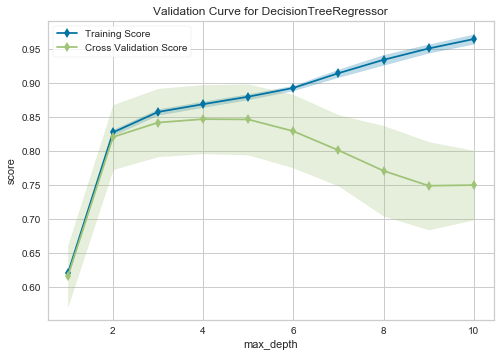

In [9]:
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    DecisionTreeRegressor(), param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="r2"
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

Based on the validation curve, we see the optimal depth is at 3. Beyond that point two curves start to diverge which means overfitting.

#### Build Decision Tree Model

In [10]:

regressor2 = DecisionTreeRegressor(max_depth = 3)
regressor2.fit(X_train, y_train)

y_pred = regressor2.predict(X_test)

df = pd.DataFrame({'Actual': y_test,'Predicted':y_pred})



#### Model Evaluation Metrics

In [11]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)  

0.882017038339453

The model gives R^2 0.88 which is slightly better than our linear regression model.

#### Tree Visualization

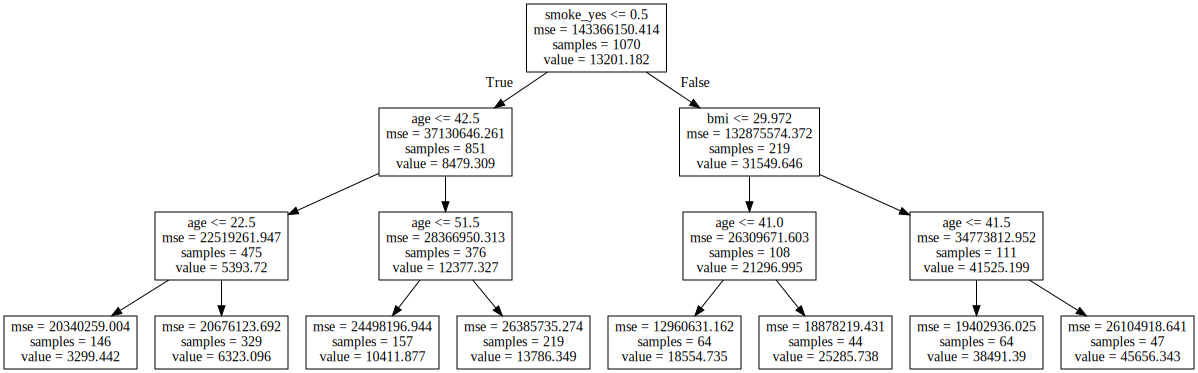

In [12]:
from graphviz import Source
from IPython.display import SVG
from IPython.display import display
from sklearn import tree

import os
os.environ["PATH"] += os.pathsep + 'D:/graphviz/bin/'

graph = Source(tree.export_graphviz(regressor2,out_file = None, filled = None, feature_names = col_names))
display(SVG(graph.pipe(format = 'svg')))

** Problem 2.**

Now use the [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) on the insurance data set. Use validation curves to optimize the hyperparameters. Estimate generalization error on 3 rounds of 10 fold cross validation. Instead of learning curves, examine the importance of the features. How does this compare with your linear regression from before?

Code below is built based on reference: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

#### Validation Curve

In [13]:
from sklearn.ensemble import RandomForestRegressor

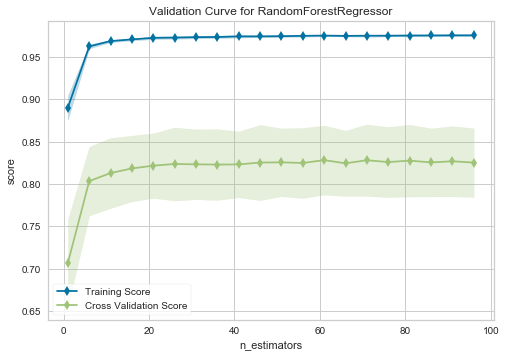

In [14]:
viz = ValidationCurve(RandomForestRegressor(), param_name="n_estimators",
    param_range=np.arange(1,100,5), cv=10, scoring="r2")
# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

Based on the validation curve, we can see the optimal n_estimators is around 25

#### Build Random Forest Model

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Import the model we are using

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 25, random_state = 0)
# Train the model on training data
rf.fit(X_train, y_train);


#### Model Evaluation Metrics

In [16]:
# Use the forest's predict method on the test data
y_pred = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 2587.06 degrees.


In [17]:
test_score = r2_score(y_test,y_pred)
print(f'Test data R-2 score: {test_score:>5.3}')

Test data R-2 score: 0.872


The R^2 is similar to our linear regression model

#### Feature Importance

In [18]:
# Get numerical feature importances
feature_list = list(X.columns)
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: smoke_yes            Importance: 0.61
Variable: bmi                  Importance: 0.23
Variable: age                  Importance: 0.13
Variable: children             Importance: 0.02
Variable: male                 Importance: 0.01


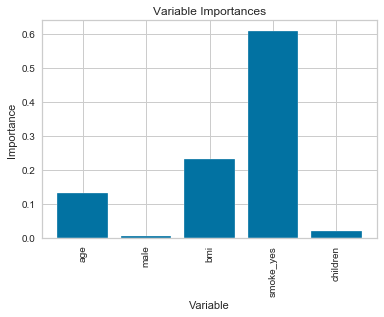

In [19]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
#plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Here we can see smoker status and bmi are the top 3 important features which is align with our linear regression resutls.